In [2]:
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32 = True
    torch.set_float32_matmul_precision('high')


NameError: name 'torch' is not defined

In [3]:
import cuml, cupy as cp
from cuml.svm import SVC
X = cp.random.random((2000, 64), dtype=cp.float32)
y = (cp.sum(X, axis=1) > 32).astype(cp.int32)
clf = SVC(kernel="linear", C=1.0, max_iter=10000)
clf.fit(X, y)
print("GPU OK, coef shape:", clf.coef_.shape)


[2025-08-31 22:28:01.774] [CUML] [warning] SVC with the linear kernel can be much faster using the specialized solver provided by LinearSVC. Consider switching to LinearSVC if tranining takes too long.
GPU OK, coef shape: (1, 64)


In [4]:
import numpy as np
from cuml.svm import SVC
import cuml, cupy as cp

print("cuML version:", cuml.__version__)
print("CUDA device:", cp.cuda.runtime.getDevice())

# 10000 x 1024 的隨機資料（float32）
X = np.random.rand(10000, 1024).astype('float32')
y = np.random.randint(0, 2, size=10000).astype('int32')

clf = SVC(kernel="linear", C=1.0, max_iter=100000, tol=1e-3)
clf.fit(X, y)
print("✅ cuML SVM (GPU) OK")


cuML version: 25.08.00
CUDA device: 0
✅ cuML SVM (GPU) OK


In [2]:
# ===== GPU 版 CLIP→SVM（讀 JSON split + 強制 cuML）=====
from pathlib import Path
import os, json, random, numpy as np

from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

# -------- 基本參數（改這裡） --------
SEED = 42
random.seed(SEED); np.random.seed(SEED)

OUT_ROOT      = Path("/home/yaya/ai-detect-proj/Script/features_256")
CLIP_REAL_DIR = OUT_ROOT / "clip_pooled_real_npy"
CLIP_FAKE_DIR = OUT_ROOT / "clip_pooled_fake_npy"

SPLIT_JSON = Path("/home/yaya/ai-detect-proj/Script/splits/combined_split.bak_1755837907.json")
SPLIT_KEY  = "iid"          # 例："iid" 或 "ood_gen.sd3" 或 "smoke_10p"
N_PER_CLASS = None          # 每類最多載入多少（None=不限制）
C = 1.0                     # SVM C（越大越貼訓練集）

# -------- 檢查路徑 --------
def list_npy(d: Path): 
    return sorted([p for p in d.glob("*.npy")])

def fid(p: Path): 
    return p.stem

real_files = list_npy(CLIP_REAL_DIR)
fake_files = list_npy(CLIP_FAKE_DIR)
assert real_files and fake_files, "❌ 找不到 CLIP 特徵 .npy，請先完成特徵抽取。"

id2path = {"real": {fid(p): p for p in real_files},
           "fake": {fid(p): p for p in fake_files}}

# -------- 讀 split.json（支援新舊兩種格式）--------
def load_split_ids(json_path: Path, split_key: str):
    assert json_path.exists(), f"❌ split 檔不存在：{json_path}"
    data = json.loads(json_path.read_text(encoding="utf-8"))
    node = data
    # 支援兩種格式：
    # A) 新：{ "iid": {"train":[...], "val":[...], "test":[...]}, "ood_gen": {...}, "smoke_10p": {...} }
    # B) 舊：{ "ids": {"train":[...], "val":[...], "test":[...]} }
    if "ids" in node and (split_key is None or split_key == "" or split_key == "ids"):
        node = node["ids"]
    else:
        # dot-path 導航
        for k in split_key.split("."):
            if k.strip():
                node = node[k]
    assert all(k in node for k in ("train","val","test")), f"❌ split 結構不含 train/val/test：{split_key}"
    return node["train"], node["val"], node["test"]

train_ids_all, val_ids_all, test_ids_all = load_split_ids(SPLIT_JSON, SPLIT_KEY)

def intersect_ids(need_ids, pool_dict):
    return [i for i in need_ids if i in pool_dict]

def make_splits_from_json():
    def pick(ids, cls):
        arr = intersect_ids(ids, id2path[cls])
        if N_PER_CLASS is not None:
            arr = arr[:min(len(arr), N_PER_CLASS)]
        return arr
    splits = {
        "train": [(i,0) for i in pick(train_ids_all, "real")] + [(i,1) for i in pick(train_ids_all, "fake")],
        "val":   [(i,0) for i in pick(val_ids_all,   "real")] + [(i,1) for i in pick(val_ids_all,   "fake")],
        "test":  [(i,0) for i in pick(test_ids_all,  "real")] + [(i,1) for i in pick(test_ids_all,  "fake")],
    }
    # 報告缺漏
    miss_real = sum(1 for i in train_ids_all+val_ids_all+test_ids_all if (i not in id2path["real"]) and (i.split("__",1)[0] in {"imagenet","flickr30k","unsplash"}))
    miss_fake = sum(1 for i in train_ids_all+val_ids_all+test_ids_all if (i not in id2path["fake"]) and (i.split("__",1)[0] not in {"imagenet","flickr30k","unsplash"}))
    if miss_real or miss_fake:
        print(f"⚠️ split 中有 {miss_real} 個 real / {miss_fake} 個 fake ID 未在檔案夾找到，已忽略。")
    for sp in splits:
        random.shuffle(splits[sp])
        n0 = sum(1 for _,y in splits[sp] if y==0); n1 = len(splits[sp])-n0
        print(f"{sp}: total={len(splits[sp])} | real={n0} fake={n1}")
    return splits

splits = make_splits_from_json()

# -------- 載入向量（含 L2 normalize）--------
def load_pairs(pairs):
    X, y = [], []
    for i, lab in pairs:
        p = id2path["real" if lab==0 else "fake"][i]
        v = np.load(p, allow_pickle=False)
        v = v.astype(np.float32, copy=False).reshape(-1)
        n = np.linalg.norm(v) + 1e-8
        v = v / n
        X.append(v)
        y.append(lab)
    return np.stack(X, 0), np.array(y, dtype=np.int32)

X_train, y_train = load_pairs(splits["train"])
X_val,   y_val   = load_pairs(splits["val"])
X_test,  y_test  = load_pairs(splits["test"])
print("shapes:", X_train.shape, X_val.shape, X_test.shape)

# -------- cuML（必須）→ 使用 Logistic Regression 產生 logit --------
try:
    import cuml, cupy as cp
    from cuml.linear_model import LogisticRegression
except Exception as e:
    raise RuntimeError(
        "❌ 找不到 cuML。請先以 mamba 安裝：\n"
        "mamba create -n rapids-24 -c rapidsai -c nvidia -c conda-forge cuml=24.* python=3.10 cuda-version=12.* -y\n"
        "mamba activate rapids-24\n"
    ) from e

print("✅ 使用 cuML GPU LogisticRegression | cuML", cuml.__version__)

# 轉成 GPU 陣列（沿用你前面的 X_train/y_train 等，保持 L2 normalize）
Xtr = cp.asarray(X_train); ytr = cp.asarray(y_train)
Xva = cp.asarray(X_val);   yva = cp.asarray(y_val)
Xte = cp.asarray(X_test);  yte = cp.asarray(y_test)

# -------- 訓練（Logistic Regression；輸出 logit）--------
logreg = LogisticRegression(
    C=C,                 # 與 sklearn 相同定義：C 越大正則越弱
    fit_intercept=True,
    max_iter=100000,
    tol=1e-4
)
logreg.fit(Xtr, ytr)

# -------- 評估（decision_function = logit；閾值 0 等價於機率 0.5）--------
def evaluate_scores_from_logit(y_true_np, logit_np, name):
    import numpy as np
    from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
    y_pred = (logit_np > 0).astype(np.int32)     # logit>0 → fake(=1)
    acc = accuracy_score(y_true_np, y_pred)
    auc = roc_auc_score(y_true_np, logit_np)     # AUC 用連續 logit 即可
    print(f"[{name}] acc={acc:.4f} auc={auc:.4f}")
    print(confusion_matrix(y_true_np, y_pred))
    print(classification_report(y_true_np, y_pred, target_names=["real","fake"], digits=4))

logit_val = logreg.decision_function(Xva).get()
logit_te  = logreg.decision_function(Xte).get()

evaluate_scores_from_logit(y_val,  logit_val, "val(logit)")
evaluate_scores_from_logit(y_test, logit_te,  "test(logit)")

# （可選）需要機率時：p = sigmoid(logit)
import numpy as np
def sigmoid(z): return 1.0 / (1.0 + np.exp(-z))
p_val = sigmoid(logit_val)   # fake 的機率
p_te  = sigmoid(logit_te)

# -------- 儲存（標註 score_kind=logit）--------
from joblib import dump
SAVE_DIR = Path("/home/yaya/ai-detect-proj/Script/saved_models")
SAVE_DIR.mkdir(parents=True, exist_ok=True)

artifacts = {
    "backend":   "cuml",
    "model":     logreg,
    "score_kind":"logit",   # 之後推論清楚知道這是 logit
    # 若你想保險也存 classes_（有些版本提供）：
    "classes_":  getattr(logreg, "classes_", None)
}
dump(artifacts, SAVE_DIR / "clip_logreg_gpu.pkl")
print(f"✅ saved: {SAVE_DIR/'clip_logreg_gpu.pkl'}")

⚠️ split 中有 0 個 real / 30000 個 fake ID 未在檔案夾找到，已忽略。
train: total=132576 | real=67200 fake=65376
val: total=16572 | real=8400 fake=8172
test: total=16572 | real=8400 fake=8172
shapes: (132576, 1024) (16572, 1024) (16572, 1024)
✅ 使用 cuML GPU LogisticRegression | cuML 25.08.00
[val(logit)] acc=0.9321 auc=0.9754
[[8040  360]
 [ 766 7406]]
              precision    recall  f1-score   support

        real     0.9130    0.9571    0.9346      8400
        fake     0.9536    0.9063    0.9294      8172

    accuracy                         0.9321     16572
   macro avg     0.9333    0.9317    0.9320     16572
weighted avg     0.9330    0.9321    0.9320     16572

[test(logit)] acc=0.9292 auc=0.9767
[[7995  405]
 [ 769 7403]]
              precision    recall  f1-score   support

        real     0.9123    0.9518    0.9316      8400
        fake     0.9481    0.9059    0.9265      8172

    accuracy                         0.9292     16572
   macro avg     0.9302    0.9288    0.9291     16572
w

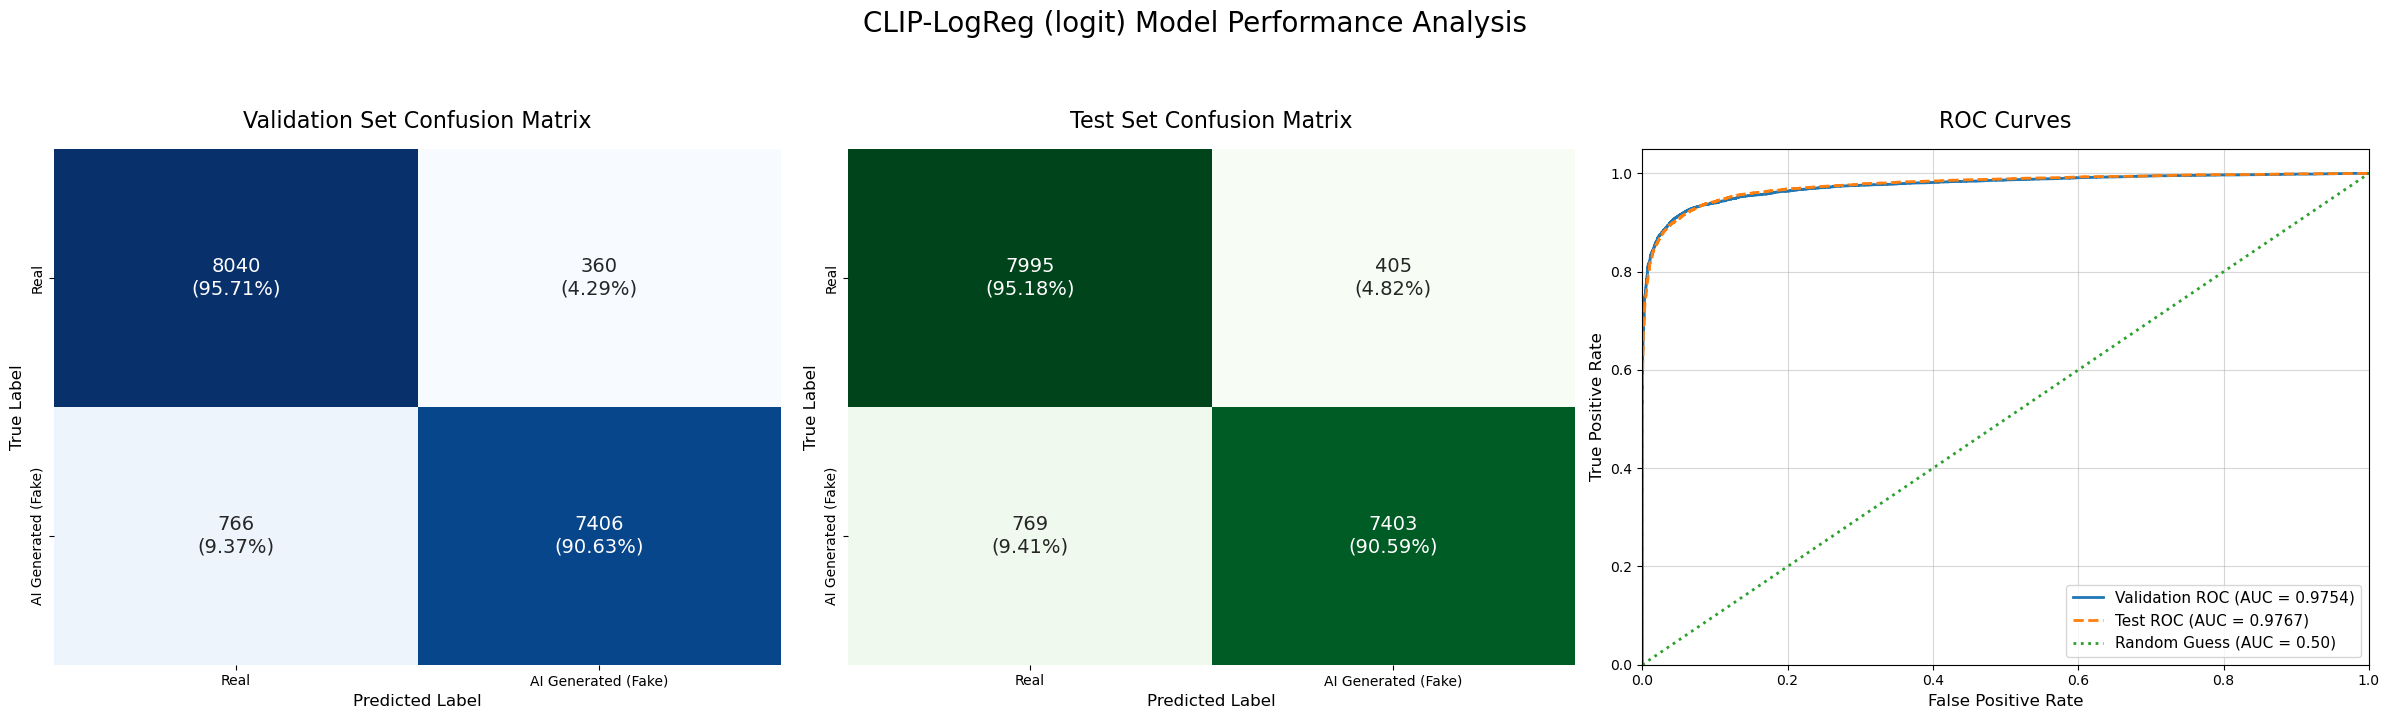

In [4]:
# =====================================================
#    生成 CLIP-LogReg (logit) 成果圖表 (整合版)
# =====================================================
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
import numpy as np

# --- 0. 期待上游已計算好這幾個變數 ---
# logit_val, y_val, logit_te, y_test
# logit > 0 代表「fake(=1)」，< 0 代表「real(=0)」

# 若你仍是 s_val/s_te，取消下兩行註解即可相容：
# logit_val = s_val
# logit_te  = s_te

# --- 1. 準備預測與指標 ---
y_pred_val  = (logit_val > 0).astype(np.int32)
y_pred_test = (logit_te  > 0).astype(np.int32)
labels_en = ["Real", "AI Generated (Fake)"]

# 混淆矩陣（計數 & 列向百分比）
cm_val  = confusion_matrix(y_val,  y_pred_val,  labels=[0,1])
cm_test = confusion_matrix(y_test, y_pred_test, labels=[0,1])

def cm_with_row_percent(cm):
    row_sum = cm.sum(axis=1, keepdims=True)
    # 避免除以 0
    cm_pct = np.divide(cm, np.maximum(row_sum, 1), where=row_sum!=0)
    annot = [f"{cnt}\n({pct:.2%})" for cnt, pct in zip(cm.flatten(), cm_pct.flatten())]
    return cm_pct, np.array(annot).reshape(2,2)

cm_val_pct,  annot_val  = cm_with_row_percent(cm_val)
cm_test_pct, annot_test = cm_with_row_percent(cm_test)

# ROC（以 logit 當 score；也可以改用機率）
fpr_val,  tpr_val,  _ = roc_curve(y_val,  logit_val)
fpr_test, tpr_test, _ = roc_curve(y_test, logit_te)
auc_val  = roc_auc_score(y_val,  logit_val)
auc_test = roc_auc_score(y_test, logit_te)

# --- 2. 繪圖 (1x3) ---
fig, axes = plt.subplots(1, 3, figsize=(24, 7))
fig.suptitle('CLIP-LogReg (logit) Model Performance Analysis', fontsize=20, y=1.02)

# 2a: 驗證集混淆矩陣
sns.heatmap(cm_val, annot=annot_val, fmt='', cmap='Blues', ax=axes[0],
            xticklabels=labels_en, yticklabels=labels_en, annot_kws={"size": 14}, cbar=False)
axes[0].set_title('Validation Set Confusion Matrix', fontsize=16, pad=15)
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)

# 2b: 測試集混淆矩陣
sns.heatmap(cm_test, annot=annot_test, fmt='', cmap='Greens', ax=axes[1],
            xticklabels=labels_en, yticklabels=labels_en, annot_kws={"size": 14}, cbar=False)
axes[1].set_title('Test Set Confusion Matrix', fontsize=16, pad=15)
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)

# 2c: ROC 曲線
axes[2].plot(fpr_val,  tpr_val,  lw=2, label=f'Validation ROC (AUC = {auc_val:.4f})')
axes[2].plot(fpr_test, tpr_test, lw=2, linestyle='--', label=f'Test ROC (AUC = {auc_test:.4f})')
axes[2].plot([0, 1], [0, 1], lw=2, linestyle=':', label='Random Guess (AUC = 0.50)')
axes[2].set_xlim([0.0, 1.0])
axes[2].set_ylim([0.0, 1.05])
axes[2].set_xlabel('False Positive Rate', fontsize=12)
axes[2].set_ylabel('True Positive Rate', fontsize=12)
axes[2].set_title('ROC Curves', fontsize=16, pad=15)
axes[2].legend(loc="lower right", fontsize=11)
axes[2].grid(alpha=0.5)

# --- 3. 輸出 ---
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("clip_logreg_performance_summary_en.png", dpi=300)
plt.show()


In [2]:
# ================== Fast CNN for PRNU / ELA (Unified Split + Smoke + GPU AMP) ==================
# 依需求先裝：  %pip -q install -U tqdm scikit-learn

from pathlib import Path
import os, json, random, time, math
import numpy as np

# --- tqdm：使用 console 版，不依賴 ipywidgets（避免 IProgress 錯誤） ---
try:
    from tqdm import tqdm
except Exception:
    def tqdm(x, **kwargs): return x
TQDM_KW = dict(leave=False, mininterval=0.1)

# ---------------- 配置（改這裡） ----------------
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# 根路徑
SCRIPT_ROOT = Path("/home/yaya/ai-detect-proj/Script")
FEA_ROOT    = SCRIPT_ROOT / "features_256"
SPLIT_JSON  = SCRIPT_ROOT / "splits/combined_split.bak_1755837907.json"  # 你剛產生的 unified split

# 選要訓練的特徵
FEATURE       = "prnu"           # "prnu" 或 "ela"
SPLIT_KEY     = "iid"      # "iid" / "smoke_10p" / "ood_gen_strict.sd3" 等
SMOKE_FRAC    = None             # 若你用 unified 的 smoke_10p，這裡就設 None；想再抽 10% 可設 0.1
N_PER_CLASS   = None             # 每類上限；None 不限制

# I/O 與快取
CACHE_MODE    = "ram"            # "ram"（快、workers=0）或 "memmap"（配合 SSD 與 workers>0）
PIN_MEMORY    = True

# 訓練超參
BATCH         = 32 if FEATURE=="prnu" else 64  # ELA 128×128 可用較大 batch；OOM 再下修
EPOCHS        = 25
LR            = 2e-3
WEIGHT_DECAY  = 1e-4
EARLY_STOP    = 5

SAVE_DIR      = SCRIPT_ROOT / "saved_models"; SAVE_DIR.mkdir(parents=True, exist_ok=True)
BEST_PATH     = SAVE_DIR / (f"{FEATURE}_fastcnn_best_42.pt" if SPLIT_KEY!="smoke_10p" else f"{FEATURE}_fastcnn_smoke_best.pt")

# ---------------- 依 FEATURE 設定資料夾 ----------------
if FEATURE == "prnu":
    REAL_DIR = FEA_ROOT / "prnu_real_npy"
    FAKE_DIR = FEA_ROOT / "prnu_fake_npy"
elif FEATURE == "ela":
    REAL_DIR = FEA_ROOT / "ela_real_npy"
    FAKE_DIR = FEA_ROOT / "ela_fake_npy"
else:
    raise ValueError("FEATURE 必須為 'prnu' 或 'ela'")
assert REAL_DIR.exists() and FAKE_DIR.exists(), f"找不到 {FEATURE} 資料夾"

# ---------------- 掃檔與 ID 映射 ----------------
def list_npy(d: Path): return sorted(p for p in d.glob("*.npy"))
real_files = list_npy(REAL_DIR); fake_files = list_npy(FAKE_DIR)
assert real_files and fake_files, f"{FEATURE} 的 .npy 空空的"

def fid(p: Path): return p.stem
id2path = {"real": {fid(p): p for p in real_files},
           "fake": {fid(p): p for p in fake_files}}

# ---------------- 讀 unified split（支援 dot-path） ----------------
def load_split_ids(json_path: Path, split_key: str):
    assert json_path.exists(), f"split 檔不存在：{json_path}"
    data = json.loads(json_path.read_text(encoding="utf-8"))
    node = data
    if "ids" in node and split_key in (None, "", "ids"):
        node = node["ids"]
    else:
        for k in split_key.split("."):
            node = node[k]
    assert all(k in node for k in ("train","val","test")), f"split 結構缺 train/val/test：{split_key}"
    return node["train"], node["val"], node["test"]

def attach_and_cap(ids, id2path, n_per_class=None):
    pairs, miss = [], 0
    for i in ids:
        if i in id2path["real"]: pairs.append((i,0))
        elif i in id2path["fake"]: pairs.append((i,1))
        else: miss += 1
    if miss: print(f"⚠️ split 中有 {miss} 個 ID 在磁碟找不到，已忽略。")
    if n_per_class is None: return pairs
    r = [(i,y) for (i,y) in pairs if y==0]
    f = [(i,y) for (i,y) in pairs if y==1]
    return r[:min(len(r), n_per_class)] + f[:min(len(f), n_per_class)]

tr_ids, va_ids, te_ids = load_split_ids(SPLIT_JSON, SPLIT_KEY)
train_pairs = attach_and_cap(tr_ids, id2path, N_PER_CLASS)
val_pairs   = attach_and_cap(va_ids, id2path, N_PER_CLASS)
test_pairs  = attach_and_cap(te_ids, id2path, N_PER_CLASS)

def stratified_frac(pairs, frac, seed=SEED):
    if not frac or frac>=1: return pairs
    R = [(i,y) for (i,y) in pairs if y==0]; F = [(i,y) for (i,y) in pairs if y==1]
    rnd = random.Random(seed)
    rnd.shuffle(R); rnd.shuffle(F)
    return R[:max(1,int(len(R)*frac))] + F[:max(1,int(len(F)*frac))]

if SMOKE_FRAC:
    train_pairs = stratified_frac(train_pairs, SMOKE_FRAC, SEED)
    val_pairs   = stratified_frac(val_pairs,   SMOKE_FRAC, SEED+1)
    test_pairs  = stratified_frac(test_pairs,  SMOKE_FRAC, SEED+2)

for name, pairs in [("train",train_pairs),("val",val_pairs),("test",test_pairs)]:
    n0 = sum(1 for _,y in pairs if y==0); n1 = len(pairs)-n0
    print(f"{name}: total={len(pairs)} | real={n0} fake={n1}")

# ---------------- Dataset / DataLoader ----------------
import torch
from torch.utils.data import Dataset, DataLoader

class FeatNPY(Dataset):
    """
    支援：
    - PRNU: int8（-127..127 對稱量化）→ float32[-1,1] → per-sample 去均值
    - ELA : int8(offset128)/uint8/float → 還原 [0,1] → per-channel 去均值（≈中心化到 [-0.5,0.5]）
    """
    def __init__(self, pairs, id2path, feature="prnu", augment=False, cache_mode="ram"):
        self.pairs = list(pairs)
        self.id2p  = id2path
        self.feature = feature
        self.augment = augment
        self.cache_mode = cache_mode
        self.cache = [None]*len(self.pairs) if cache_mode=="ram" else None

        if self.cache is not None:
            for i,(idx,lab) in enumerate(self.pairs):
                d = "real" if lab==0 else "fake"
                p = self.id2p[d][idx]
                self.cache[i] = np.load(p, allow_pickle=False).copy()

    def __len__(self): return len(self.pairs)

    def _prep_prnu(self, arr):
        x = (arr.astype(np.float32) / 127.0)
        x = x - x.mean()
        x = np.clip(x, -2.0, 2.0)
        if x.ndim==2: x = x[None,...]
        elif x.ndim==3: x = x.mean(-1, keepdims=True).transpose(2,0,1)
        return x

    def _prep_ela(self, arr):
        if arr.dtype == np.int8:
            x = (arr.astype(np.float32) + 128.0) / 255.0
        elif arr.dtype == np.uint8:
            x = arr.astype(np.float32) / 255.0
        else:
            x = arr.astype(np.float32)
            if x.max()>1.5: x = x/255.0
            else: x = np.clip(x, 0.0, 1.0)
        if x.ndim==2: x = x[None,...]
        elif x.ndim==3: x = x.transpose(2,0,1)
        x = x - x.reshape(x.shape[0], -1).mean(-1, keepdims=True).reshape(x.shape[0],1,1)
        x = np.clip(x, -2.0, 2.0)
        return x

    def __getitem__(self, i):
        idx, lab = self.pairs[i]
        try:
            if self.cache_mode == "ram":
                arr = self.cache[i]
            else:
                d = "real" if lab==0 else "fake"
                p = self.id2p[d][idx]
                arr = np.load(p, allow_pickle=False, mmap_mode='r' if self.cache_mode=="memmap" else None)
        except Exception as e:
            d = "real" if lab==0 else "fake"
            p = self.id2p[d].get(idx, "<missing>")
            raise RuntimeError(f"[LoadFail] id={idx} label={lab} path={p} :: {e}")

        if self.feature=="prnu": x = self._prep_prnu(arr)
        else: x = self._prep_ela(arr)

        # 輕量增強（需要時再開）
        # if self.augment and self.feature=="prnu":
        #     x = x + np.random.normal(0.0, 0.01, size=x.shape).astype(np.float32)

        return torch.from_numpy(x), torch.tensor(lab, dtype=torch.long)

# DataLoader 參數：RAM 快取 → workers=0；memmap → 開 workers
if CACHE_MODE == "ram":
    NUM_WORKERS, PERSISTENT, PREFETCH_FACTOR = 0, False, None
else:
    NUM_WORKERS = min(4, os.cpu_count() or 1)
    PERSISTENT, PREFETCH_FACTOR = True, 2

def make_loader(pairs, train=False):
    ds = FeatNPY(pairs, id2path, feature=FEATURE, augment=train, cache_mode=CACHE_MODE)
    kwargs = dict(batch_size=BATCH, shuffle=train, pin_memory=PIN_MEMORY, drop_last=train)
    if NUM_WORKERS and NUM_WORKERS>0:
        kwargs.update(num_workers=NUM_WORKERS, prefetch_factor=PREFETCH_FACTOR, persistent_workers=PERSISTENT)
    return DataLoader(ds, **kwargs)

train_loader = make_loader(train_pairs, train=True)
val_loader   = make_loader(val_pairs,   train=False)
test_loader  = make_loader(test_pairs,  train=False)

# ---------------- 模型 ----------------
import torch.nn as nn

class DSBlock(nn.Module):
    def __init__(self, c_in, c_out, stride=1):
        super().__init__()
        self.dw = nn.Conv2d(c_in, c_in, 3, stride=stride, padding=1, groups=c_in, bias=False)
        self.bn1= nn.BatchNorm2d(c_in)
        self.pw = nn.Conv2d(c_in, c_out, 1, bias=False)
        self.bn2= nn.BatchNorm2d(c_out)
        self.act = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.act(self.bn1(self.dw(x)))
        x = self.act(self.bn2(self.pw(x)))
        return x

class FastCNN(nn.Module):
    def __init__(self, nc=1, num_classes=2):
        super().__init__()
        self.stem = nn.Sequential(nn.Conv2d(nc,32,3,padding=1,bias=False), nn.BatchNorm2d(32), nn.ReLU(inplace=True))
        self.stage = nn.Sequential(
            DSBlock(32, 64, 1),     # 256
            DSBlock(64, 128, 2),    # 128
            DSBlock(128,128,1),     # 128
            DSBlock(128,256,2),     # 64
            DSBlock(256,256,1),     # 64
        )
        self.head = nn.Sequential(nn.Conv2d(256,256,1,bias=False), nn.BatchNorm2d(256), nn.ReLU(inplace=True))
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.drop = nn.Dropout(0.2)
        self.fc   = nn.Linear(256,2)
    def forward(self, x):
        x = self.stem(x); x = self.stage(x); x = self.head(x)
        x = self.pool(x).flatten(1); x = self.drop(x)
        return self.fc(x)

# ---------------- 訓練 & 評估 ----------------
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

def evaluate(model, loader, device):
    model.eval()
    ys, logits = [], []
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device, non_blocking=True).contiguous(memory_format=torch.channels_last)
            y = y.to(device, non_blocking=True)
            out = model(x)
            logits.append(out.detach().cpu().numpy())
            ys.append(y.detach().cpu().numpy())
    logits = np.concatenate(logits, 0)
    y_true = np.concatenate(ys, 0)
    y_pred = logits.argmax(1)
    acc = (y_pred==y_true).mean()
    prob1 = torch.softmax(torch.from_numpy(logits), dim=1).numpy()[:,1]
    auc = roc_auc_score(y_true, prob1)
    return acc, auc, y_true, y_pred, prob1

def train():
    torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("cuda:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("GPU:", torch.cuda.get_device_name(0))
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
        torch.set_float32_matmul_precision('high')
    torch.backends.cudnn.benchmark = True

    # 掃一個 batch 決定通道數（ELA 可能是 1 或 3）
    _xb, _ = next(iter(train_loader))
    nc = int(_xb.shape[1])
    print(f"Detected input channels: {nc} (FEATURE={FEATURE})")

    model = FastCNN(nc=nc).to(device).to(memory_format=torch.channels_last)
    AMP_DTYPE = torch.bfloat16 if (torch.cuda.is_available() and torch.cuda.is_bf16_supported()) else torch.float16
    USE_SCALER = (AMP_DTYPE == torch.float16)
    scaler = torch.cuda.amp.GradScaler(enabled=USE_SCALER)

    # 類別權重
    n0 = sum(1 for _,y in train_pairs if y==0); n1 = len(train_pairs)-n0
    w = torch.tensor([1.0/max(n0,1), 1.0/max(n1,1)], dtype=torch.float32, device=device); w = w/w.mean()

    crit  = nn.CrossEntropyLoss(weight=w)
    optim = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=EPOCHS)

    best_auc, best_state, no_imp = -1.0, None, 0
    for ep in range(1, EPOCHS+1):
        model.train(); losses=[]
        pbar = tqdm(train_loader, desc=f"train ep{ep}", **TQDM_KW)
        for x,y in pbar:
            x = x.to(device, non_blocking=True).contiguous(memory_format=torch.channels_last)
            y = y.to(device, non_blocking=True)
            with torch.cuda.amp.autocast(dtype=AMP_DTYPE):
                out  = model(x)
                loss = crit(out, y)
            optim.zero_grad(set_to_none=True)
            if USE_SCALER:
                scaler.scale(loss).backward(); scaler.step(optim); scaler.update()
            else:
                loss.backward(); optim.step()
            losses.append(loss.item())
            pbar.set_postfix(loss=f"{np.mean(losses):.4f}")
        sched.step()

        va_acc, va_auc, *_ = evaluate(model, val_loader, device)
        print(f"[EP {ep:02d}] train_loss={np.mean(losses):.4f} | val acc={va_acc:.4f} auc={va_auc:.4f}")

        if va_auc > best_auc:
            best_auc = va_auc; no_imp = 0
            best_state = {"model": model.state_dict(),
                          "meta": {"arch":"FastCNN","feature":FEATURE,"nc":nc,"seed":SEED,
                                   "epochs_done":ep,"val_auc":float(va_auc),"val_acc":float(va_acc)}}
            torch.save(best_state, BEST_PATH)
            print("  ↳ saved best:", BEST_PATH)
        else:
            no_imp += 1
            if no_imp >= EARLY_STOP:
                print(f"⏹ Early stop: {EARLY_STOP} epochs no AUC improvement")
                break

    # 測試
    if best_state is None and BEST_PATH.exists():
        best_state = torch.load(BEST_PATH, map_location="cpu")
    if best_state is not None: model.load_state_dict(best_state["model"])
    te_acc, te_auc, y_true, y_pred, _ = evaluate(model, test_loader, device)
    print(f"[TEST] acc={te_acc:.4f} auc={te_auc:.4f}")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=["real","fake"], digits=4))
    return model

model = train()

# ---- 單張 .npy 推論 ----
def predict_npy(npy_path: Path, feature=FEATURE):
    arr = np.load(npy_path, allow_pickle=False)
    if feature=="prnu":
        x = arr.astype(np.float32)/127.0; x = x - x.mean()
        if x.ndim==2: x = x[None,...]
        elif x.ndim==3: x = x.mean(-1, keepdims=True).transpose(2,0,1)
    else:
        if arr.dtype==np.int8: x = (arr.astype(np.float32)+128.0)/255.0
        elif arr.dtype==np.uint8: x = arr.astype(np.float32)/255.0
        else:
            x = arr.astype(np.float32); x = x/255.0 if x.max()>1.5 else np.clip(x,0,1)
        if x.ndim==2: x = x[None,...]
        elif x.ndim==3: x = x.transpose(2,0,1)
        x = x - x.reshape(x.shape[0], -1).mean(-1, keepdims=True).reshape(x.shape[0],1,1)
    x = torch.from_numpy(x[None,...])
    device = next(model.parameters()).device
    AMP_DTYPE = torch.bfloat16 if (torch.cuda.is_available() and torch.cuda.is_bf16_supported()) else torch.float16
    with torch.no_grad(), torch.cuda.amp.autocast(dtype=AMP_DTYPE):
        logit = model(x.to(device).contiguous(memory_format=torch.channels_last))
        prob  = torch.softmax(logit, dim=1)[0,1].item()
        pred  = int(prob >= 0.5)
    return pred, prob


train: total=132576 | real=67200 fake=65376
val: total=16572 | real=8400 fake=8172
test: total=16572 | real=8400 fake=8172
cuda: True
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
Detected input channels: 1 (FEATURE=prnu)


/tmp/ipykernel_3105/969355688.py:276: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_SCALER)
train ep1:   0%|          | 0/4143 [00:00<?, ?it/s]/tmp/ipykernel_3105/969355688.py:293: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=AMP_DTYPE):


[EP 01] train_loss=0.3092 | val acc=0.9121 auc=0.9612
  ↳ saved best: /home/yaya/ai-detect-proj/Script/saved_models/prnu_fastcnn_best_42.pt


train ep2:   0%|          | 0/4143 [00:00<?, ?it/s]/tmp/ipykernel_3105/969355688.py:293: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=AMP_DTYPE):


[EP 02] train_loss=0.2506 | val acc=0.9198 auc=0.9649
  ↳ saved best: /home/yaya/ai-detect-proj/Script/saved_models/prnu_fastcnn_best_42.pt


train ep3:   0%|          | 0/4143 [00:00<?, ?it/s]/tmp/ipykernel_3105/969355688.py:293: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=AMP_DTYPE):


[EP 03] train_loss=0.2272 | val acc=0.9211 auc=0.9700
  ↳ saved best: /home/yaya/ai-detect-proj/Script/saved_models/prnu_fastcnn_best_42.pt


train ep4:   0%|          | 0/4143 [00:00<?, ?it/s]/tmp/ipykernel_3105/969355688.py:293: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=AMP_DTYPE):


[EP 04] train_loss=0.2143 | val acc=0.9275 auc=0.9699


train ep5:   0%|          | 0/4143 [00:00<?, ?it/s]/tmp/ipykernel_3105/969355688.py:293: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=AMP_DTYPE):


[EP 05] train_loss=0.2028 | val acc=0.9310 auc=0.9736
  ↳ saved best: /home/yaya/ai-detect-proj/Script/saved_models/prnu_fastcnn_best_42.pt


train ep6:   0%|          | 0/4143 [00:00<?, ?it/s]/tmp/ipykernel_3105/969355688.py:293: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=AMP_DTYPE):


[EP 06] train_loss=0.1941 | val acc=0.9350 auc=0.9750
  ↳ saved best: /home/yaya/ai-detect-proj/Script/saved_models/prnu_fastcnn_best_42.pt


train ep7:   0%|          | 0/4143 [00:00<?, ?it/s]/tmp/ipykernel_3105/969355688.py:293: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=AMP_DTYPE):


[EP 07] train_loss=0.1852 | val acc=0.9316 auc=0.9724


train ep8:   0%|          | 0/4143 [00:00<?, ?it/s]/tmp/ipykernel_3105/969355688.py:293: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=AMP_DTYPE):


[EP 08] train_loss=0.1783 | val acc=0.9330 auc=0.9736


train ep9:   0%|          | 0/4143 [00:00<?, ?it/s]/tmp/ipykernel_3105/969355688.py:293: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=AMP_DTYPE):


[EP 09] train_loss=0.1690 | val acc=0.9300 auc=0.9750


train ep10:   0%|          | 0/4143 [00:00<?, ?it/s]/tmp/ipykernel_3105/969355688.py:293: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=AMP_DTYPE):


[EP 10] train_loss=0.1601 | val acc=0.9372 auc=0.9755
  ↳ saved best: /home/yaya/ai-detect-proj/Script/saved_models/prnu_fastcnn_best_42.pt


train ep11:   0%|          | 0/4143 [00:00<?, ?it/s]/tmp/ipykernel_3105/969355688.py:293: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=AMP_DTYPE):


[EP 11] train_loss=0.1504 | val acc=0.9306 auc=0.9753


train ep12:   0%|          | 0/4143 [00:00<?, ?it/s]/tmp/ipykernel_3105/969355688.py:293: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=AMP_DTYPE):


[EP 12] train_loss=0.1387 | val acc=0.9276 auc=0.9748


train ep13:   0%|          | 0/4143 [00:00<?, ?it/s]/tmp/ipykernel_3105/969355688.py:293: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=AMP_DTYPE):


[EP 13] train_loss=0.1265 | val acc=0.9275 auc=0.9746


train ep14:   0%|          | 0/4143 [00:00<?, ?it/s]/tmp/ipykernel_3105/969355688.py:293: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=AMP_DTYPE):


[EP 14] train_loss=0.1132 | val acc=0.9273 auc=0.9718


train ep15:   0%|          | 0/4143 [00:00<?, ?it/s]/tmp/ipykernel_3105/969355688.py:293: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=AMP_DTYPE):


[EP 15] train_loss=0.0996 | val acc=0.9312 auc=0.9731
⏹ Early stop: 5 epochs no AUC improvement
[TEST] acc=0.9340 auc=0.9752
[[8015  385]
 [ 709 7463]]
              precision    recall  f1-score   support

        real     0.9187    0.9542    0.9361      8400
        fake     0.9509    0.9132    0.9317      8172

    accuracy                         0.9340     16572
   macro avg     0.9348    0.9337    0.9339     16572
weighted avg     0.9346    0.9340    0.9339     16572



In [ ]:
# ==========================================================
#         呼叫訓練函式，並接收模型與歷史紀錄
# ==========================================================
# 原本的 model = train() 改成：
model, history = train()


# ==========================================================
#         生成 FastCNN 訓練成果圖表 (英文)
# ==========================================================
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. 準備數據 ---
epochs_range = range(1, len(history['train_loss']) + 1)
train_loss = history['train_loss']
val_acc = history['val_acc']
val_auc = history['val_auc']
test_results = history['test_results']
cm_test = confusion_matrix(test_results['y_true'], test_results['y_pred'])
labels_en = ["Real", "AI Generated (Fake)"]

# --- 2. 繪製整合圖表 (1x2 排版) ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle(f'{FEATURE.upper()}-FastCNN Model Training Summary', fontsize=20, y=1.02)


# --- 圖 4a: 學習曲線 (Learning Curves) ---
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy / AUC', color='tab:blue', fontsize=12)
ax1.plot(epochs_range, val_acc, 'o-', color='tab:blue', label='Validation Accuracy')
ax1.plot(epochs_range, val_auc, 's--', color='tab:cyan', label='Validation AUC')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend(loc='lower left')

# 創建第二個 Y 軸共享 X 軸
ax1_twin = ax1.twinx()
ax1_twin.set_ylabel('Loss', color='tab:red', fontsize=12)
ax1_twin.plot(epochs_range, train_loss, '^-', color='tab:red', label='Training Loss')
ax1_twin.tick_params(axis='y', labelcolor='tab:red')
ax1_twin.legend(loc='lower right')

ax1.set_title('Training & Validation Metrics per Epoch', fontsize=16, pad=15)


# --- 圖 4b: 最終測試集混淆矩陣 ---
cm_test_percent = cm_test / cm_test.sum(axis=1, keepdims=True)
annot_test = [f"{value}\n({percent:.2%})" for value, percent in zip(cm_test.flatten(), cm_test_percent.flatten())]
annot_test = np.array(annot_test).reshape(2, 2)

sns.heatmap(cm_test, annot=annot_test, fmt='', cmap='Oranges', ax=ax2,
            xticklabels=labels_en, yticklabels=labels_en, annot_kws={"size": 14}, cbar=False)
ax2.set_title(f'Final Test Set Confusion Matrix\n(Acc: {test_results["acc"]:.4f}, AUC: {test_results["auc"]:.4f})', fontsize=16, pad=15)
ax2.set_xlabel('Predicted Label', fontsize=12)
ax2.set_ylabel('True Label', fontsize=12)


# --- 最終調整並儲存 ---
plt.tight_layout(rect=[0, 0, 1, 0.95]) # 調整佈局以容納大標題
plt.savefig(f"{FEATURE}_cnn_performance_summary_en.png", dpi=300)
plt.show()

/tmp/ipykernel_3105/969355688.py:276: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler(enabled=USE_SCALER)


cuda: True
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
Detected input channels: 1 (FEATURE=prnu)


train ep1:   0%|          | 0/4143 [00:00<?, ?it/s]/tmp/ipykernel_3105/969355688.py:293: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=AMP_DTYPE):


[EP 01] train_loss=0.3092 | val acc=0.9121 auc=0.9612
  ↳ saved best: /home/yaya/ai-detect-proj/Script/saved_models/prnu_fastcnn_best_42.pt


train ep2:   0%|          | 0/4143 [00:00<?, ?it/s]/tmp/ipykernel_3105/969355688.py:293: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=AMP_DTYPE):


[EP 02] train_loss=0.2506 | val acc=0.9198 auc=0.9649
  ↳ saved best: /home/yaya/ai-detect-proj/Script/saved_models/prnu_fastcnn_best_42.pt


train ep3:   0%|          | 0/4143 [00:00<?, ?it/s]/tmp/ipykernel_3105/969355688.py:293: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=AMP_DTYPE):


[EP 03] train_loss=0.2272 | val acc=0.9211 auc=0.9700
  ↳ saved best: /home/yaya/ai-detect-proj/Script/saved_models/prnu_fastcnn_best_42.pt


train ep4:   0%|          | 0/4143 [00:00<?, ?it/s]/tmp/ipykernel_3105/969355688.py:293: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=AMP_DTYPE):


[EP 04] train_loss=0.2143 | val acc=0.9275 auc=0.9699


train ep5:   0%|          | 0/4143 [00:00<?, ?it/s]/tmp/ipykernel_3105/969355688.py:293: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=AMP_DTYPE):


[EP 05] train_loss=0.2028 | val acc=0.9310 auc=0.9736
  ↳ saved best: /home/yaya/ai-detect-proj/Script/saved_models/prnu_fastcnn_best_42.pt


train ep6:   0%|          | 0/4143 [00:00<?, ?it/s]/tmp/ipykernel_3105/969355688.py:293: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=AMP_DTYPE):


[EP 06] train_loss=0.1941 | val acc=0.9350 auc=0.9750
  ↳ saved best: /home/yaya/ai-detect-proj/Script/saved_models/prnu_fastcnn_best_42.pt


train ep7:   0%|          | 0/4143 [00:00<?, ?it/s]/tmp/ipykernel_3105/969355688.py:293: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=AMP_DTYPE):
train ep7:  28%|██▊       | 1168/4143 [02:23<06:15,  7.93it/s, loss=0.1834]

In [ ]:
# ================== Fast CNN for PRNU / ELA (Unified Split + Smoke + GPU AMP) ==================
# 依需求先裝：  %pip -q install -U tqdm scikit-learn

from pathlib import Path
import os, json, random, time, math
import numpy as np

# --- tqdm：使用 console 版，不依賴 ipywidgets（避免 IProgress 錯誤） ---
try:
    from tqdm import tqdm
except Exception:
    def tqdm(x, **kwargs): return x
TQDM_KW = dict(leave=False, mininterval=0.1)

# ---------------- 配置（改這裡） ----------------
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# 根路徑
SCRIPT_ROOT = Path("/home/yaya/ai-detect-proj/Script")
FEA_ROOT    = SCRIPT_ROOT / "features_256"
SPLIT_JSON  = SCRIPT_ROOT / "splits/combined_split.bak_1755837907.json"  # 你剛產生的 unified split

# 選要訓練的特徵
FEATURE       = "ela"           # "prnu" 或 "ela"
SPLIT_KEY     = "iid"      # "iid" / "smoke_10p" / "ood_gen_strict.sd3" 等
SMOKE_FRAC    = None             # 若你用 unified 的 smoke_10p，這裡就設 None；想再抽 10% 可設 0.1
N_PER_CLASS   = None             # 每類上限；None 不限制

# I/O 與快取
CACHE_MODE    = "ram"            # "ram"（快、workers=0）或 "memmap"（配合 SSD 與 workers>0）
PIN_MEMORY    = True

# 訓練超參
BATCH         = 32 if FEATURE=="prnu" else 64  # ELA 128×128 可用較大 batch；OOM 再下修
EPOCHS        = 25
LR            = 2e-3
WEIGHT_DECAY  = 1e-4
EARLY_STOP    = 5

SAVE_DIR      = SCRIPT_ROOT / "saved_models"; SAVE_DIR.mkdir(parents=True, exist_ok=True)
BEST_PATH     = SAVE_DIR / (f"{FEATURE}_fastcnn_best.pt" if SPLIT_KEY!="smoke_10p" else f"{FEATURE}_fastcnn_smoke_best.pt")

# ---------------- 依 FEATURE 設定資料夾 ----------------
if FEATURE == "prnu":
    REAL_DIR = FEA_ROOT / "prnu_real_npy"
    FAKE_DIR = FEA_ROOT / "prnu_fake_npy"
elif FEATURE == "ela":
    REAL_DIR = FEA_ROOT / "ela_real_npy"
    FAKE_DIR = FEA_ROOT / "ela_fake_npy"
else:
    raise ValueError("FEATURE 必須為 'prnu' 或 'ela'")
assert REAL_DIR.exists() and FAKE_DIR.exists(), f"找不到 {FEATURE} 資料夾"

# ---------------- 掃檔與 ID 映射 ----------------
def list_npy(d: Path): return sorted(p for p in d.glob("*.npy"))
real_files = list_npy(REAL_DIR); fake_files = list_npy(FAKE_DIR)
assert real_files and fake_files, f"{FEATURE} 的 .npy 空空的"

def fid(p: Path): return p.stem
id2path = {"real": {fid(p): p for p in real_files},
           "fake": {fid(p): p for p in fake_files}}

# ---------------- 讀 unified split（支援 dot-path） ----------------
def load_split_ids(json_path: Path, split_key: str):
    assert json_path.exists(), f"split 檔不存在：{json_path}"
    data = json.loads(json_path.read_text(encoding="utf-8"))
    node = data
    if "ids" in node and split_key in (None, "", "ids"):
        node = node["ids"]
    else:
        for k in split_key.split("."):
            node = node[k]
    assert all(k in node for k in ("train","val","test")), f"split 結構缺 train/val/test：{split_key}"
    return node["train"], node["val"], node["test"]

def attach_and_cap(ids, id2path, n_per_class=None):
    pairs, miss = [], 0
    for i in ids:
        if i in id2path["real"]: pairs.append((i,0))
        elif i in id2path["fake"]: pairs.append((i,1))
        else: miss += 1
    if miss: print(f"⚠️ split 中有 {miss} 個 ID 在磁碟找不到，已忽略。")
    if n_per_class is None: return pairs
    r = [(i,y) for (i,y) in pairs if y==0]
    f = [(i,y) for (i,y) in pairs if y==1]
    return r[:min(len(r), n_per_class)] + f[:min(len(f), n_per_class)]

tr_ids, va_ids, te_ids = load_split_ids(SPLIT_JSON, SPLIT_KEY)
train_pairs = attach_and_cap(tr_ids, id2path, N_PER_CLASS)
val_pairs   = attach_and_cap(va_ids, id2path, N_PER_CLASS)
test_pairs  = attach_and_cap(te_ids, id2path, N_PER_CLASS)

def stratified_frac(pairs, frac, seed=SEED):
    if not frac or frac>=1: return pairs
    R = [(i,y) for (i,y) in pairs if y==0]; F = [(i,y) for (i,y) in pairs if y==1]
    rnd = random.Random(seed)
    rnd.shuffle(R); rnd.shuffle(F)
    return R[:max(1,int(len(R)*frac))] + F[:max(1,int(len(F)*frac))]

if SMOKE_FRAC:
    train_pairs = stratified_frac(train_pairs, SMOKE_FRAC, SEED)
    val_pairs   = stratified_frac(val_pairs,   SMOKE_FRAC, SEED+1)
    test_pairs  = stratified_frac(test_pairs,  SMOKE_FRAC, SEED+2)

for name, pairs in [("train",train_pairs),("val",val_pairs),("test",test_pairs)]:
    n0 = sum(1 for _,y in pairs if y==0); n1 = len(pairs)-n0
    print(f"{name}: total={len(pairs)} | real={n0} fake={n1}")

# ---------------- Dataset / DataLoader ----------------
import torch
from torch.utils.data import Dataset, DataLoader

class FeatNPY(Dataset):
    """
    支援：
    - PRNU: int8（-127..127 對稱量化）→ float32[-1,1] → per-sample 去均值
    - ELA : int8(offset128)/uint8/float → 還原 [0,1] → per-channel 去均值（≈中心化到 [-0.5,0.5]）
    """
    def __init__(self, pairs, id2path, feature="prnu", augment=False, cache_mode="ram"):
        self.pairs = list(pairs)
        self.id2p  = id2path
        self.feature = feature
        self.augment = augment
        self.cache_mode = cache_mode
        self.cache = [None]*len(self.pairs) if cache_mode=="ram" else None

        if self.cache is not None:
            for i,(idx,lab) in enumerate(self.pairs):
                d = "real" if lab==0 else "fake"
                p = self.id2p[d][idx]
                self.cache[i] = np.load(p, allow_pickle=False).copy()

    def __len__(self): return len(self.pairs)

    def _prep_prnu(self, arr):
        x = (arr.astype(np.float32) / 127.0)
        x = x - x.mean()
        x = np.clip(x, -2.0, 2.0)
        if x.ndim==2: x = x[None,...]
        elif x.ndim==3: x = x.mean(-1, keepdims=True).transpose(2,0,1)
        return x

    def _prep_ela(self, arr):
        if arr.dtype == np.int8:
            x = (arr.astype(np.float32) + 128.0) / 255.0
        elif arr.dtype == np.uint8:
            x = arr.astype(np.float32) / 255.0
        else:
            x = arr.astype(np.float32)
            if x.max()>1.5: x = x/255.0
            else: x = np.clip(x, 0.0, 1.0)
        if x.ndim==2: x = x[None,...]
        elif x.ndim==3: x = x.transpose(2,0,1)
        x = x - x.reshape(x.shape[0], -1).mean(-1, keepdims=True).reshape(x.shape[0],1,1)
        x = np.clip(x, -2.0, 2.0)
        return x

    def __getitem__(self, i):
        idx, lab = self.pairs[i]
        try:
            if self.cache_mode == "ram":
                arr = self.cache[i]
            else:
                d = "real" if lab==0 else "fake"
                p = self.id2p[d][idx]
                arr = np.load(p, allow_pickle=False, mmap_mode='r' if self.cache_mode=="memmap" else None)
        except Exception as e:
            d = "real" if lab==0 else "fake"
            p = self.id2p[d].get(idx, "<missing>")
            raise RuntimeError(f"[LoadFail] id={idx} label={lab} path={p} :: {e}")

        if self.feature=="prnu": x = self._prep_prnu(arr)
        else: x = self._prep_ela(arr)

        # 輕量增強（需要時再開）
        # if self.augment and self.feature=="prnu":
        #     x = x + np.random.normal(0.0, 0.01, size=x.shape).astype(np.float32)

        return torch.from_numpy(x), torch.tensor(lab, dtype=torch.long)

# DataLoader 參數：RAM 快取 → workers=0；memmap → 開 workers
if CACHE_MODE == "ram":
    NUM_WORKERS, PERSISTENT, PREFETCH_FACTOR = 0, False, None
else:
    NUM_WORKERS = min(4, os.cpu_count() or 1)
    PERSISTENT, PREFETCH_FACTOR = True, 2

def make_loader(pairs, train=False):
    ds = FeatNPY(pairs, id2path, feature=FEATURE, augment=train, cache_mode=CACHE_MODE)
    kwargs = dict(batch_size=BATCH, shuffle=train, pin_memory=PIN_MEMORY, drop_last=train)
    if NUM_WORKERS and NUM_WORKERS>0:
        kwargs.update(num_workers=NUM_WORKERS, prefetch_factor=PREFETCH_FACTOR, persistent_workers=PERSISTENT)
    return DataLoader(ds, **kwargs)

train_loader = make_loader(train_pairs, train=True)
val_loader   = make_loader(val_pairs,   train=False)
test_loader  = make_loader(test_pairs,  train=False)

# ---------------- 模型 ----------------
import torch.nn as nn

class DSBlock(nn.Module):
    def __init__(self, c_in, c_out, stride=1):
        super().__init__()
        self.dw = nn.Conv2d(c_in, c_in, 3, stride=stride, padding=1, groups=c_in, bias=False)
        self.bn1= nn.BatchNorm2d(c_in)
        self.pw = nn.Conv2d(c_in, c_out, 1, bias=False)
        self.bn2= nn.BatchNorm2d(c_out)
        self.act = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.act(self.bn1(self.dw(x)))
        x = self.act(self.bn2(self.pw(x)))
        return x

class FastCNN(nn.Module):
    def __init__(self, nc=1, num_classes=2):
        super().__init__()
        self.stem = nn.Sequential(nn.Conv2d(nc,32,3,padding=1,bias=False), nn.BatchNorm2d(32), nn.ReLU(inplace=True))
        self.stage = nn.Sequential(
            DSBlock(32, 64, 1),     # 256
            DSBlock(64, 128, 2),    # 128
            DSBlock(128,128,1),     # 128
            DSBlock(128,256,2),     # 64
            DSBlock(256,256,1),     # 64
        )
        self.head = nn.Sequential(nn.Conv2d(256,256,1,bias=False), nn.BatchNorm2d(256), nn.ReLU(inplace=True))
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.drop = nn.Dropout(0.2)
        self.fc   = nn.Linear(256,2)
    def forward(self, x):
        x = self.stem(x); x = self.stage(x); x = self.head(x)
        x = self.pool(x).flatten(1); x = self.drop(x)
        return self.fc(x)

# ---------------- 訓練 & 評估 ----------------
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix

def evaluate(model, loader, device):
    model.eval()
    ys, logits = [], []
    with torch.no_grad():
        for x,y in loader:
            x = x.to(device, non_blocking=True).contiguous(memory_format=torch.channels_last)
            y = y.to(device, non_blocking=True)
            out = model(x)
            logits.append(out.detach().cpu().numpy())
            ys.append(y.detach().cpu().numpy())
    logits = np.concatenate(logits, 0)
    y_true = np.concatenate(ys, 0)
    y_pred = logits.argmax(1)
    acc = (y_pred==y_true).mean()
    prob1 = torch.softmax(torch.from_numpy(logits), dim=1).numpy()[:,1]
    auc = roc_auc_score(y_true, prob1)
    return acc, auc, y_true, y_pred, prob1

def train():
    torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("cuda:", torch.cuda.is_available())
    if torch.cuda.is_available():
        print("GPU:", torch.cuda.get_device_name(0))
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
        torch.set_float32_matmul_precision('high')
    torch.backends.cudnn.benchmark = True

    # 掃一個 batch 決定通道數（ELA 可能是 1 或 3）
    _xb, _ = next(iter(train_loader))
    nc = int(_xb.shape[1])
    print(f"Detected input channels: {nc} (FEATURE={FEATURE})")

    model = FastCNN(nc=nc).to(device).to(memory_format=torch.channels_last)
    AMP_DTYPE = torch.bfloat16 if (torch.cuda.is_available() and torch.cuda.is_bf16_supported()) else torch.float16
    USE_SCALER = (AMP_DTYPE == torch.float16)
    scaler = torch.cuda.amp.GradScaler(enabled=USE_SCALER)

    # 類別權重
    n0 = sum(1 for _,y in train_pairs if y==0); n1 = len(train_pairs)-n0
    w = torch.tensor([1.0/max(n0,1), 1.0/max(n1,1)], dtype=torch.float32, device=device); w = w/w.mean()

    crit  = nn.CrossEntropyLoss(weight=w)
    optim = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    sched = torch.optim.lr_scheduler.CosineAnnealingLR(optim, T_max=EPOCHS)

    best_auc, best_state, no_imp = -1.0, None, 0
    for ep in range(1, EPOCHS+1):
        model.train(); losses=[]
        pbar = tqdm(train_loader, desc=f"train ep{ep}", **TQDM_KW)
        for x,y in pbar:
            x = x.to(device, non_blocking=True).contiguous(memory_format=torch.channels_last)
            y = y.to(device, non_blocking=True)
            with torch.cuda.amp.autocast(dtype=AMP_DTYPE):
                out  = model(x)
                loss = crit(out, y)
            optim.zero_grad(set_to_none=True)
            if USE_SCALER:
                scaler.scale(loss).backward(); scaler.step(optim); scaler.update()
            else:
                loss.backward(); optim.step()
            losses.append(loss.item())
            pbar.set_postfix(loss=f"{np.mean(losses):.4f}")
        sched.step()

        va_acc, va_auc, *_ = evaluate(model, val_loader, device)
        print(f"[EP {ep:02d}] train_loss={np.mean(losses):.4f} | val acc={va_acc:.4f} auc={va_auc:.4f}")

        if va_auc > best_auc:
            best_auc = va_auc; no_imp = 0
            best_state = {"model": model.state_dict(),
                          "meta": {"arch":"FastCNN","feature":FEATURE,"nc":nc,"seed":SEED,
                                   "epochs_done":ep,"val_auc":float(va_auc),"val_acc":float(va_acc)}}
            torch.save(best_state, BEST_PATH)
            print("  ↳ saved best:", BEST_PATH)
        else:
            no_imp += 1
            if no_imp >= EARLY_STOP:
                print(f"⏹ Early stop: {EARLY_STOP} epochs no AUC improvement")
                break

    # 測試
    if best_state is None and BEST_PATH.exists():
        best_state = torch.load(BEST_PATH, map_location="cpu")
    if best_state is not None: model.load_state_dict(best_state["model"])
    te_acc, te_auc, y_true, y_pred, _ = evaluate(model, test_loader, device)
    print(f"[TEST] acc={te_acc:.4f} auc={te_auc:.4f}")
    print(confusion_matrix(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=["real","fake"], digits=4))
    return model

model = train()

# ---- 單張 .npy 推論 ----
def predict_npy(npy_path: Path, feature=FEATURE):
    arr = np.load(npy_path, allow_pickle=False)
    if feature=="prnu":
        x = arr.astype(np.float32)/127.0; x = x - x.mean()
        if x.ndim==2: x = x[None,...]
        elif x.ndim==3: x = x.mean(-1, keepdims=True).transpose(2,0,1)
    else:
        if arr.dtype==np.int8: x = (arr.astype(np.float32)+128.0)/255.0
        elif arr.dtype==np.uint8: x = arr.astype(np.float32)/255.0
        else:
            x = arr.astype(np.float32); x = x/255.0 if x.max()>1.5 else np.clip(x,0,1)
        if x.ndim==2: x = x[None,...]
        elif x.ndim==3: x = x.transpose(2,0,1)
        x = x - x.reshape(x.shape[0], -1).mean(-1, keepdims=True).reshape(x.shape[0],1,1)
    x = torch.from_numpy(x[None,...])
    device = next(model.parameters()).device
    AMP_DTYPE = torch.bfloat16 if (torch.cuda.is_available() and torch.cuda.is_bf16_supported()) else torch.float16
    with torch.no_grad(), torch.cuda.amp.autocast(dtype=AMP_DTYPE):
        logit = model(x.to(device).contiguous(memory_format=torch.channels_last))
        prob  = torch.softmax(logit, dim=1)[0,1].item()
        pred  = int(prob >= 0.5)
    return pred, prob


In [ ]:
# ==========================================================
#         呼叫訓練函式，並接收模型與歷史紀錄
# ==========================================================
# 原本的 model = train() 改成：
model, history = train()


# ==========================================================
#         生成 FastCNN 訓練成果圖表 (英文)
# ==========================================================
import matplotlib.pyplot as plt
import seaborn as sns

# --- 1. 準備數據 ---
epochs_range = range(1, len(history['train_loss']) + 1)
train_loss = history['train_loss']
val_acc = history['val_acc']
val_auc = history['val_auc']
test_results = history['test_results']
cm_test = confusion_matrix(test_results['y_true'], test_results['y_pred'])
labels_en = ["Real", "AI Generated (Fake)"]

# --- 2. 繪製整合圖表 (1x2 排版) ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle(f'{FEATURE.upper()}-FastCNN Model Training Summary', fontsize=20, y=1.02)


# --- 圖 4a: 學習曲線 (Learning Curves) ---
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy / AUC', color='tab:blue', fontsize=12)
ax1.plot(epochs_range, val_acc, 'o-', color='tab:blue', label='Validation Accuracy')
ax1.plot(epochs_range, val_auc, 's--', color='tab:cyan', label='Validation AUC')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.grid(axis='y', linestyle='--', alpha=0.7)
ax1.legend(loc='lower left')

# 創建第二個 Y 軸共享 X 軸
ax1_twin = ax1.twinx()
ax1_twin.set_ylabel('Loss', color='tab:red', fontsize=12)
ax1_twin.plot(epochs_range, train_loss, '^-', color='tab:red', label='Training Loss')
ax1_twin.tick_params(axis='y', labelcolor='tab:red')
ax1_twin.legend(loc='lower right')

ax1.set_title('Training & Validation Metrics per Epoch', fontsize=16, pad=15)


# --- 圖 4b: 最終測試集混淆矩陣 ---
cm_test_percent = cm_test / cm_test.sum(axis=1, keepdims=True)
annot_test = [f"{value}\n({percent:.2%})" for value, percent in zip(cm_test.flatten(), cm_test_percent.flatten())]
annot_test = np.array(annot_test).reshape(2, 2)

sns.heatmap(cm_test, annot=annot_test, fmt='', cmap='Oranges', ax=ax2,
            xticklabels=labels_en, yticklabels=labels_en, annot_kws={"size": 14}, cbar=False)
ax2.set_title(f'Final Test Set Confusion Matrix\n(Acc: {test_results["acc"]:.4f}, AUC: {test_results["auc"]:.4f})', fontsize=16, pad=15)
ax2.set_xlabel('Predicted Label', fontsize=12)
ax2.set_ylabel('True Label', fontsize=12)


# --- 最終調整並儲存 ---
plt.tight_layout(rect=[0, 0, 1, 0.95]) # 調整佈局以容納大標題
plt.savefig(f"{FEATURE}_cnn_performance_summary_en.png", dpi=300)
plt.show()

In [8]:
import os
os.environ["PYTHONUTF8"] = "1"     # 等效於 python -X utf8
os.environ["PYTHONIOENCODING"] = "utf-8"


In [1]:
# ===================== 三模型融合評測（PRNU-CNN / ELA-CNN / CLIP-LogReg優先）
# ============== UTF-8 + JSON 序列化安全整合版（可直接貼上執行） ==============
from pathlib import Path
import os, json, random, numpy as np

# ---------- 全域設定 ----------
SEED = 42
random.seed(SEED); np.random.seed(SEED)

# 避免 Windows/WSL 的 ASCII 既定編碼影響
os.environ.setdefault("PYTHONUTF8", "1")
os.environ.setdefault("PYTHONIOENCODING", "utf-8")

SCRIPT_ROOT = Path("/home/yaya/ai-detect-proj/Script")
FEA_ROOT    = SCRIPT_ROOT / "features_256"
SPLIT_JSON  = SCRIPT_ROOT / "splits/combined_split.bak_1755837907.json"
SPLIT_KEY   = "iid"   # 可換 "ood_gen.sd3" / "smoke_10p"

# CLIP（池化後，每張圖一個 1024 維 .npy，已 L2 normalize）
CLIP_POOL_REAL = FEA_ROOT / "clip_pooled_real_npy"
CLIP_POOL_FAKE = FEA_ROOT / "clip_pooled_fake_npy"

# PRNU / ELA 特徵（每張圖一個 .npy）
PRNU_REAL = FEA_ROOT / "prnu_real_npy"; PRNU_FAKE = FEA_ROOT / "prnu_fake_npy"
ELA_REAL  = FEA_ROOT / "ela_real_npy";  ELA_FAKE  = FEA_ROOT / "ela_fake_npy"

# 已訓練模型權重（CLIP 優先找 LogReg；若無才回退 SVM）
PRNU_MODEL_PATH    = SCRIPT_ROOT / "saved_models/prnu_fastcnn_best.pt"
ELA_MODEL_PATH     = SCRIPT_ROOT / "saved_models/ela_fastcnn_best.pt"
CLIP_LOGREG_CUML   = SCRIPT_ROOT / "saved_models/clip_logreg_gpu.pkl"     # 新：cuML LogisticRegression
CLIP_SVM_CUML      = SCRIPT_ROOT / "saved_models/clip_svm_gpu.pkl"        # 舊：cuML SVM（回退用）
CLIP_SVM_TORCH     = SCRIPT_ROOT / "saved_models/clip_svm_gpu_torch.pt"   # 舊：PyTorch 線性層（回退用）

SAVE_DIR = SCRIPT_ROOT / "saved_models"
SAVE_DIR.mkdir(parents=True, exist_ok=True)

# ---------- 安全 JSON 工具（UTF-8 + 可序列化） ----------
def to_jsonable(obj):
    """把不可序列化型別轉為 JSON 友善格式：set/tuple→list、Path→str、numpy/cupy/torch→python。"""
    import numpy as _np
    try:
        import cupy as _cp
    except Exception:
        _cp = None
    try:
        import torch as _torch
    except Exception:
        _torch = None

    if obj is None or isinstance(obj, (bool, int, float, str)):
        return obj
    if isinstance(obj, Path):
        return str(obj)
    if isinstance(obj, (list, tuple, set)):
        return [to_jsonable(x) for x in obj]
    if isinstance(obj, dict):
        return {str(k): to_jsonable(v) for k, v in obj.items()}
    if 'numpy' in type(obj).__module__:
        if isinstance(obj, _np.ndarray):
            return obj.tolist()
        if isinstance(obj, _np.generic):
            return obj.item()
    if _cp is not None and 'cupy' in type(obj).__module__:
        return to_jsonable(_cp.asnumpy(obj))
    if _torch is not None and isinstance(obj, _torch.Tensor):
        return obj.detach().cpu().tolist()
    return str(obj)

def read_json_utf8(path: Path):
    with path.open("r", encoding="utf-8") as f:
        return json.load(f)

def write_json_utf8(path: Path, obj):
    s = json.dumps(to_jsonable(obj), ensure_ascii=False, indent=2)
    path.write_text(s, encoding="utf-8")

# ---------- 共用資料工具 ----------
def load_split_ids(json_path: Path, split_key: str):
    data = read_json_utf8(json_path)
    node = data
    for k in split_key.split("."):
        node = node[k]
    return node["train"], node["val"], node["test"]

def scan_id2path(d: Path):
    return {p.stem: p for p in d.glob("*.npy")} if d.exists() else {}

id2clip = {"real": scan_id2path(CLIP_POOL_REAL), "fake": scan_id2path(CLIP_POOL_FAKE)}
id2prnu = {"real": scan_id2path(PRNU_REAL),      "fake": scan_id2path(PRNU_FAKE)}
id2ela  = {"real": scan_id2path(ELA_REAL),       "fake": scan_id2path(ELA_FAKE)}

def attach_tri(ids):
    """只保留同時存在 PRNU/ELA/CLIP 三模態的樣本，並貼上標籤（0 real / 1 fake）。"""
    pairs=[]
    miss_real=miss_fake=0
    for i in ids:
        if i in id2clip["real"] and i in id2prnu["real"] and i in id2ela["real"]:
            pairs.append((i,0))
        elif i in id2clip["fake"] and i in id2prnu["fake"] and i in id2ela["fake"]:
            pairs.append((i,1))
        else:
            # 簡單統計遺失
            if i.split("__",1)[0] in {"imagenet","flickr30k","unsplash"}:
                miss_real += 1
            else:
                miss_fake += 1
    if miss_real or miss_fake:
        print(f"⚠️ 缺漏（被忽略）：real={miss_real} fake={miss_fake}")
    return pairs

tr_ids, va_ids, te_ids = load_split_ids(SPLIT_JSON, SPLIT_KEY)
val_pairs  = attach_tri(va_ids)
test_pairs = attach_tri(te_ids)
print(f"val N={len(val_pairs)} | test N={len(test_pairs)}")

# ---------- PRNU / ELA：FastCNN（推論用） ----------
import torch, torch.nn as nn
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DSBlock(nn.Module):
    def __init__(self, c_in, c_out, stride=1):
        super().__init__()
        self.dw = nn.Conv2d(c_in, c_in, 3, stride=stride, padding=1, groups=c_in, bias=False)
        self.bn1= nn.BatchNorm2d(c_in)
        self.pw = nn.Conv2d(c_in, c_out, 1, bias=False)
        self.bn2= nn.BatchNorm2d(c_out)
        self.act = nn.ReLU(inplace=True)
    def forward(self, x):
        x = self.act(self.bn1(self.dw(x)))
        x = self.act(self.bn2(self.pw(x)))
        return x

class FastCNN_1ch(nn.Module):
    def __init__(self, base=32, num_classes=2):
        super().__init__()
        self.stem = nn.Sequential(
            nn.Conv2d(1, base, 3, padding=1, bias=False),
            nn.BatchNorm2d(base),
            nn.ReLU(inplace=True)
        )
        self.stage = nn.Sequential(
            DSBlock(base,   base*2, stride=1),
            DSBlock(base*2, base*4, stride=2),
            DSBlock(base*4, base*4, stride=1),
            DSBlock(base*4, base*8, stride=2),
            DSBlock(base*8, base*8, stride=1),
        )
        self.head = nn.Sequential(
            nn.Conv2d(base*8, base*8, 1, bias=False),
            nn.BatchNorm2d(base*8),
            nn.ReLU(inplace=True)
        )
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc   = nn.Linear(base*8, num_classes)
    def forward(self, x):
        x = self.stem(x)
        x = self.stage(x)
        x = self.head(x)
        x = self.pool(x).flatten(1)
        return self.fc(x)

def _load_cnn(path: Path):
    m = FastCNN_1ch().to(device).eval()
    sd = torch.load(path, map_location=device)
    if isinstance(sd, dict) and ("model" in sd or "state_dict" in sd):
        sd = sd.get("model", sd.get("state_dict"))
    m.load_state_dict(sd)
    return m

prnu_model = _load_cnn(PRNU_MODEL_PATH)
ela_model  = _load_cnn(ELA_MODEL_PATH)

@torch.no_grad()
def prnu_logit(ids_pairs):
    scores = []
    for iid,lab in ids_pairs:
        p = id2prnu["real" if lab==0 else "fake"][iid]
        arr = np.load(p, allow_pickle=False).astype(np.float32)  # 形如 int8 或 float
        x = (arr/127.0); x = x - x.mean()
        t = torch.from_numpy(x[None,None,...]).to(device).contiguous(memory_format=torch.channels_last)
        logit = prnu_model(t)
        prob1 = torch.softmax(logit, dim=1)[0,1].item()
        prob1 = min(max(prob1, 1e-6), 1-1e-6)
        scores.append(np.log(prob1/(1-prob1)))
    return np.array(scores, dtype=np.float32)

@torch.no_grad()
def ela_logit(ids_pairs):
    scores = []
    for iid,lab in ids_pairs:
        p = id2ela["real" if lab==0 else "fake"][iid]
        a = np.load(p, allow_pickle=False)
        if a.dtype == np.int8:
            x = (a.astype(np.float32)+128.0)/255.0
        elif a.dtype == np.uint8:
            x = a.astype(np.float32)/255.0
        else:
            x = a.astype(np.float32); x = x/255.0 if x.max()>1.5 else x
        x = x - x.mean()
        t = torch.from_numpy(x[None,None,...]).to(device).contiguous(memory_format=torch.channels_last)
        logit = ela_model(t)
        prob1 = torch.softmax(logit, dim=1)[0,1].item()
        prob1 = min(max(prob1, 1e-6), 1-1e-6)
        scores.append(np.log(prob1/(1-prob1)))
    return np.array(scores, dtype=np.float32)

# ---------- CLIP：LogReg 優先；SVM 回退 + Platt 標定成 logit ----------
def clip_vec(iid, lab):
    p = id2clip["real" if lab==0 else "fake"][iid]
    v = np.load(p, allow_pickle=False).astype(np.float32)  # (D,) 已 L2
    return v

class CLIPScorer:
    def __init__(self):
        self.mode = None   # 'logreg' 或 'svm'
        self.backend = None
        self.model = None
        self.platt = None  # SVM 的校準器（sklearn LR）
        self._load_model()

    def _load_model(self):
        if CLIP_LOGREG_CUML.exists():
            import joblib
            obj = joblib.load(CLIP_LOGREG_CUML)
            self.model = obj["model"] if isinstance(obj, dict) and "model" in obj else obj
            self.mode = "logreg"; self.backend = "cuml"
            print("✅ CLIP backend: cuML LogisticRegression (logit)")
            return
        if CLIP_SVM_CUML.exists():
            import joblib
            obj = joblib.load(CLIP_SVM_CUML)
            self.model = obj["model"] if isinstance(obj, dict) and "model" in obj else obj
            self.mode = "svm"; self.backend = "cuml"
            print("⚠️ 使用舊 CLIP SVM（cuml），將在 val 上做 Platt 標定為 logit")
            return
        if CLIP_SVM_TORCH.exists():
            sd = torch.load(CLIP_SVM_TORCH, map_location="cpu")
            lin = torch.nn.Linear(sd["D"], 1, bias=True)
            lin.load_state_dict(sd["state_dict"])
            lin.eval()
            self.model = lin
            self.mode = "svm"; self.backend = "torch"
            print("⚠️ 使用舊 CLIP SVM（torch），將在 val 上做 Platt 標定為 logit")
            return
        raise FileNotFoundError("找不到任何 CLIP 模型（優先 clip_logreg_gpu.pkl；回退 clip_svm_*）")

    def decision_raw(self, ids_pairs):
        # 回傳原始分數（logit 或 SVM margin）
        if self.backend == "cuml":
            import cupy as cp
            X = cp.asarray(np.stack([clip_vec(i,y) for i,y in ids_pairs], 0))
            s = self.model.decision_function(X).get()
            return s.astype(np.float32)
        elif self.backend == "torch":
            X = torch.from_numpy(np.stack([clip_vec(i,y) for i,y in ids_pairs], 0)).float()
            with torch.no_grad():
                s = self.model(X).squeeze(1).numpy()
            return s.astype(np.float32)
        else:
            raise RuntimeError("Unknown CLIP backend")

    def fit_platt_on_val(self, ids_pairs, y_true):
        if self.mode != "svm":
            return
        from sklearn.linear_model import LogisticRegression
        s_val = self.decision_raw(ids_pairs).reshape(-1,1)
        self.platt = LogisticRegression(solver="liblinear", max_iter=1000, random_state=SEED).fit(s_val, y_true)
        print("✅ 已對 SVM 做 Platt 標定（基於 val）")

    def predict_logit(self, ids_pairs):
        s = self.decision_raw(ids_pairs)
        if self.mode == "logreg":
            return s
        else:
            assert self.platt is not None, "SVM 尚未標定，請先在 val 上呼叫 fit_platt_on_val(...)"
            p = self.platt.predict_proba(s.reshape(-1,1))[:,1]
            p = np.clip(p, 1e-6, 1-1e-6)
            return np.log(p/(1-p)).astype(np.float32)

clip_scorer = CLIPScorer()

# ---------- 取得各模態在 val/test 的「logit」 ----------
y_val  = np.array([y for _,y in val_pairs],  dtype=np.int32)
y_test = np.array([y for _,y in test_pairs], dtype=np.int32)

print("→ computing modality logits on val/test ...")
val_prnu = prnu_logit(val_pairs)
val_ela  = ela_logit(val_pairs)
if clip_scorer.mode == "svm":
    clip_scorer.fit_platt_on_val(val_pairs, y_val)
val_clip = clip_scorer.predict_logit(val_pairs)

test_prnu = prnu_logit(test_pairs)
test_ela  = ela_logit(test_pairs)
test_clip = clip_scorer.predict_logit(test_pairs)

# ---------- 融合器（sklearn LogisticRegression；若不可用則 simplex 權重） ----------
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report, confusion_matrix

def report_single(name, y, logit_arr):
    prob = 1/(1+np.exp(-logit_arr))
    auc = roc_auc_score(y, prob); acc = accuracy_score(y, (prob>=0.5).astype(int))
    print(f"[{name}] acc={acc:.4f} auc={auc:.4f}")
    return prob

print("\n=== 單模態（val）===")
_ = report_single("PRNU", y_val,  val_prnu)
_ = report_single("ELA ", y_val,  val_ela)
_ = report_single("CLIP", y_val,  val_clip)

# stacking on logits
try:
    from sklearn.linear_model import LogisticRegression
    Xv = np.stack([val_prnu, val_ela, val_clip], 1)
    fuser = LogisticRegression(max_iter=1000, solver="liblinear", random_state=SEED)
    fuser.fit(Xv, y_val)
    proba_val = fuser.predict_proba(Xv)[:,1]
    print(f"Fusion (LR on val) AUC={roc_auc_score(y_val, proba_val):.4f}")
except Exception as e:
    print("⚠️ sklearn 不可用，改用簡單權重搜尋：", e)
    best_auc, best_w = -1, (1/3,1/3,1/3)
    for w1 in np.linspace(0,1,21):
        for w2 in np.linspace(0,1-w1,21):
            w3 = 1 - w1 - w2
            z = w1*val_prnu + w2*val_ela + w3*val_clip
            prob = 1/(1+np.exp(-z))
            auc = roc_auc_score(y_val, prob)
            if auc > best_auc:
                best_auc, best_w = auc, (w1,w2,w3)
    class Dummy:
        def __init__(self, w): self.w = np.asarray(w, np.float32)
        def predict_proba(self, X):
            z = X @ self.w
            sig = 1/(1+np.exp(-z))
            return np.stack([1-sig, sig], 1)
    fuser = Dummy(best_w)
    print("Best weights (val):", best_w, "AUC=", best_auc)

# ---------- 保存融合器與 meta（UTF-8 + 可序列化） ----------
try:
    import joblib
    joblib.dump(fuser, SAVE_DIR / "fusion_lr.pkl")
    print("✅ saved:", SAVE_DIR / "fusion_lr.pkl")
except Exception as e:
    print("⚠️ joblib 不可用，略過 pkl：", e)

def search_simplex_weights(scores_tuple, y, step=0.05):
    v1, v2, v3 = scores_tuple
    best_auc, best_w = -1, (1/3, 1/3, 1/3)
    for w1 in np.arange(0, 1+1e-9, step):
        for w2 in np.arange(0, 1-w1+1e-9, step):
            w3 = 1 - w1 - w2
            z = w1*v1 + w2*v2 + w3*v3
            prob = 1/(1+np.exp(-z))
            auc = roc_auc_score(y, prob)
            if auc > best_auc:
                best_auc, best_w = auc, (float(w1), float(w2), float(w3))
    return best_w, best_auc

if "LogisticRegression" in type(fuser).__name__:
    best_w, best_auc = search_simplex_weights((val_prnu, val_ela, val_clip), y_val, step=0.05)
    meta = {
        "weights_if_no_sklearn": list(best_w),
        "auc_on_val_with_simplex": float(best_auc),
        "order": ["PRNU","ELA","CLIP"],
        "note": "sigmoid(X@w) fallback; no bias",
        "clip_mode": getattr(clip_scorer, "mode", None)
    }
else:
    meta = {
        "weights_if_no_sklearn": [float(x) for x in getattr(fuser, "w", [1/3,1/3,1/3])],
        "order": ["PRNU","ELA","CLIP"],
        "note": "sigmoid(X@w) fallback; no bias",
        "clip_mode": getattr(clip_scorer, "mode", None)
    }
write_json_utf8(SAVE_DIR / "fusion_lr_meta.json", meta)
print("✅ saved:", SAVE_DIR / "fusion_lr_meta.json")

# ---------- 在 test 上評估：單模態 & 融合 ----------
print("\n=== 單模態（test）===")
def report_single_test(name, y, logit_arr):
    prob = 1/(1+np.exp(-logit_arr))
    auc = roc_auc_score(y, prob); acc = accuracy_score(y, (prob>=0.5).astype(int))
    print(f"[{name}] acc={acc:.4f} auc={auc:.4f}")
    return prob

p_prnu = report_single_test("PRNU", y_test, test_prnu)
p_ela  = report_single_test("ELA ", y_test, test_ela)
p_clip = report_single_test("CLIP", y_test, test_clip)

Xt = np.stack([test_prnu, test_ela, test_clip], 1)  # 三路皆為 logit
p_fuse = fuser.predict_proba(Xt)[:,1]
auc = roc_auc_score(y_test, p_fuse); acc = accuracy_score(y_test, (p_fuse>=0.5).astype(int))
print("\n=== FUSION（test）===")
print(f"[Fusion] acc={acc:.4f} auc={auc:.4f}")
print(confusion_matrix(y_test, (p_fuse>=0.5).astype(int)))
print(classification_report(y_test, (p_fuse>=0.5).astype(int), target_names=["real","fake"], digits=4))

# ---------- 匯出結果（UTF-8 + 可序列化） ----------
OUT = SCRIPT_ROOT / "exports/fusion_eval" / SPLIT_KEY
OUT.mkdir(parents=True, exist_ok=True)
np.save(OUT/"proba_test_prnu.npy", p_prnu, allow_pickle=False)
np.save(OUT/"proba_test_ela.npy",  p_ela,  allow_pickle=False)
np.save(OUT/"proba_test_clip.npy", p_clip, allow_pickle=False)
np.save(OUT/"proba_test_fuse.npy", p_fuse, allow_pickle=False)

clip_model_path = (CLIP_LOGREG_CUML if CLIP_LOGREG_CUML.exists() else
                   (CLIP_SVM_CUML if CLIP_SVM_CUML.exists() else CLIP_SVM_TORCH))

out_meta = {
    "split_key": SPLIT_KEY,
    "models": {
        "prnu": PRNU_MODEL_PATH,
        "ela":  ELA_MODEL_PATH,
        "clip": clip_model_path,
    },
    "clip_mode": getattr(clip_scorer, "mode", None),
    "note": "scores of test split; fusion by LR or simplex on val; all inputs are logits"
}
write_json_utf8(OUT / "meta.json", out_meta)
print("✅ saved scores to:", OUT)


val N=16572 | test N=16572


/tmp/ipykernel_21533/418030373.py:164: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sd = torch.load(path, map_location=device)


✅ CLIP backend: cuML LogisticRegression (logit)
→ computing modality logits on val/test ...

=== 單模態（val）===
[PRNU] acc=0.9153 auc=0.9613
[ELA ] acc=0.9365 auc=0.9779
[CLIP] acc=0.9321 auc=0.9754
Fusion (LR on val) AUC=0.9875
✅ saved: /home/yaya/ai-detect-proj/Script/saved_models/fusion_lr.pkl
✅ saved: /home/yaya/ai-detect-proj/Script/saved_models/fusion_lr_meta.json

=== 單模態（test）===
[PRNU] acc=0.9181 auc=0.9628
[ELA ] acc=0.9365 auc=0.9779
[CLIP] acc=0.9292 auc=0.9767

=== FUSION（test）===
[Fusion] acc=0.9608 auc=0.9882
[[8151  249]
 [ 401 7771]]
              precision    recall  f1-score   support

        real     0.9531    0.9704    0.9617      8400
        fake     0.9690    0.9509    0.9599      8172

    accuracy                         0.9608     16572
   macro avg     0.9610    0.9606    0.9608     16572
weighted avg     0.9609    0.9608    0.9608     16572

✅ saved scores to: /home/yaya/ai-detect-proj/Script/exports/fusion_eval/iid


In [1]:
# ===================== 讀 exports/ 結果，畫 ROC / 混淆矩陣整合圖 =====================
from pathlib import Path
import os, json, numpy as np
import matplotlib.pyplot as plt

# --- 專案路徑（請按需要調整） ---
SCRIPT_ROOT = Path("/home/yaya/ai-detect-proj/Script")
FEA_ROOT    = SCRIPT_ROOT / "features_256"
EXP_ROOT    = SCRIPT_ROOT / "exports/fusion_eval"   # 下面會自動選 split 目錄
SPLIT_JSON  = SCRIPT_ROOT / "splits/combined_split.bak_1755837907.json"

# ========== 安全 JSON 工具 ==========
def read_json_utf8(path: Path):
    with path.open("r", encoding="utf-8") as f:
        return json.load(f)

# ========== 重建 y_test（用 split.json + 三模態皆存在的樣本） ==========
def scan_id2path(d: Path):
    return {p.stem: p for p in d.glob("*.npy")} if d.exists() else {}

CLIP_POOL_REAL = FEA_ROOT / "clip_pooled_real_npy"
CLIP_POOL_FAKE = FEA_ROOT / "clip_pooled_fake_npy"
PRNU_REAL = FEA_ROOT / "prnu_real_npy"; PRNU_FAKE = FEA_ROOT / "prnu_fake_npy"
ELA_REAL  = FEA_ROOT / "ela_real_npy";  ELA_FAKE  = FEA_ROOT / "ela_fake_npy"

id2clip = {"real": scan_id2path(CLIP_POOL_REAL), "fake": scan_id2path(CLIP_POOL_FAKE)}
id2prnu = {"real": scan_id2path(PRNU_REAL),      "fake": scan_id2path(PRNU_FAKE)}
id2ela  = {"real": scan_id2path(ELA_REAL),       "fake": scan_id2path(ELA_FAKE)}

def load_split_ids(json_path: Path, split_key: str):
    data = read_json_utf8(json_path)
    node = data
    for k in split_key.split("."):
        node = node[k]
    return node["train"], node["val"], node["test"]

def attach_tri(ids):
    pairs=[]
    for i in ids:
        if i in id2clip["real"] and i in id2prnu["real"] and i in id2ela["real"]:
            pairs.append((i,0))
        elif i in id2clip["fake"] and i in id2prnu["fake"] and i in id2ela["fake"]:
            pairs.append((i,1))
    return pairs

# ========== 決定要讀的 exports 目錄 ==========
# 1) 若只有一個子資料夾，就用它；2) 若多個，選最近修改；3) 也可手動指定 SPLIT_KEY 指向子資料夾名
subdirs = [p for p in EXP_ROOT.iterdir() if p.is_dir()]
assert subdirs, f"找不到 {EXP_ROOT} 的任何輸出資料夾"
exp_dir = max(subdirs, key=lambda p: p.stat().st_mtime) if len(subdirs)>1 else subdirs[0]

meta = read_json_utf8(exp_dir / "meta.json")
split_key = meta.get("split_key", exp_dir.name)
print(f"✔ 使用 exports 目錄：{exp_dir}  | split_key={split_key}")

# 重建 y_test
_, _, te_ids = load_split_ids(SPLIT_JSON, split_key)
test_pairs = attach_tri(te_ids)
y_test = np.array([y for _,y in test_pairs], dtype=np.int32)

# ========== 載入各路機率 ==========
def try_load(name):
    path = exp_dir / f"proba_test_{name}.npy"
    return np.load(path) if path.exists() else None

p_prnu = try_load("prnu")
p_ela  = try_load("ela")
p_clip = try_load("clip")
p_fuse = try_load("fuse")

# 長度檢查
n = len(y_test)
for nm, arr in [("prnu",p_prnu), ("ela",p_ela), ("clip",p_clip), ("fuse",p_fuse)]:
    if arr is not None and len(arr)!=n:
        raise ValueError(f"{nm} 機率長度 {len(arr)} 與 y_test {n} 不符（split/特徵對齊問題）")

# ========== 指標與作圖工具 ==========
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, classification_report

def cm_counts_and_annot(y_true, prob):
    y_pred = (prob>=0.5).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    row_sum = cm.sum(axis=1, keepdims=True)
    pct = np.divide(cm, np.maximum(row_sum,1), where=row_sum!=0)
    annot = np.array([f"{c}\n({p:.2%})" for c,p in zip(cm.flatten(), pct.flatten())]).reshape(2,2)
    return cm, annot

def plot_cm(ax, cm, annot, title):
    im = ax.imshow(cm, cmap="Blues")
    ax.set_title(title, fontsize=14, pad=10)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["Real","Fake"]); ax.set_yticklabels(["Real","Fake"])
    for (i,j), txt in np.ndenumerate(annot):
        ax.text(j, i, txt, ha="center", va="center", fontsize=11)
    ax.figure.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

def metrics_str(y_true, prob):
    auc = roc_auc_score(y_true, prob)
    acc = accuracy_score(y_true, (prob>=0.5).astype(int))
    return f"ACC={acc:.4f} | AUC={auc:.4f}"

# ========== 圖 1：四個混淆矩陣 ==========
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.ravel()
panels = []

if p_prnu is not None:
    cm, annot = cm_counts_and_annot(y_test, p_prnu)
    plot_cm(axes[len(panels)], cm, annot, f"PRNU  Confusion Matrix\n{metrics_str(y_test,p_prnu)}")
    panels.append("prnu")
if p_ela is not None:
    cm, annot = cm_counts_and_annot(y_test, p_ela)
    plot_cm(axes[len(panels)], cm, annot, f"ELA   Confusion Matrix\n{metrics_str(y_test,p_ela)}")
    panels.append("ela")
if p_clip is not None:
    cm, annot = cm_counts_and_annot(y_test, p_clip)
    plot_cm(axes[len(panels)], cm, annot, f"CLIP  Confusion Matrix\n{metrics_str(y_test,p_clip)}")
    panels.append("clip")
if p_fuse is not None:
    cm, annot = cm_counts_and_annot(y_test, p_fuse)
    plot_cm(axes[len(panels)], cm, annot, f"FUSION Confusion Matrix\n{metrics_str(y_test,p_fuse)}")
    panels.append("fuse")

# 把沒有使用到的子圖關掉
for k in range(len(panels), 4):
    fig.delaxes(axes[k])

fig.suptitle(f"Confusion Matrices (split={split_key})", fontsize=16, y=0.98)
fig.tight_layout(rect=[0,0,1,0.96])
out_cm = SCRIPT_ROOT / f"fusion_eval_confmat_{split_key}.png"
fig.savefig(out_cm, dpi=300)
plt.show()
print("✅ Saved:", out_cm)

# ========== 圖 2：ROC 曲線（可用的都畫上） ==========
plt.figure(figsize=(8, 7))
any_curve = False

def add_roc(prob, label):
    global any_curve
    fpr, tpr, _ = roc_curve(y_test, prob)
    auc = roc_auc_score(y_test, prob)
    plt.plot(fpr, tpr, lw=2, label=f"{label} (AUC={auc:.4f})")
    any_curve = True

if p_prnu is not None: add_roc(p_prnu, "PRNU")
if p_ela  is not None: add_roc(p_ela,  "ELA")
if p_clip is not None: add_roc(p_clip, "CLIP")
if p_fuse is not None: add_roc(p_fuse, "FUSION")

plt.plot([0,1],[0,1], lw=1, linestyle=":", label="Random")
plt.xlim([0,1]); plt.ylim([0,1.05])
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title(f"ROC Curves (split={split_key})")
plt.legend(loc="lower right", fontsize=11)
plt.grid(alpha=0.4)
out_roc = SCRIPT_ROOT / f"fusion_eval_roc_{split_key}.png"
plt.savefig(out_roc, dpi=300)
plt.show()
print("✅ Saved:", out_roc)


FileNotFoundError: [Errno 2] No such file or directory: '/home/yaya/ai-detect-proj/Script/exports/fusion_eval/ood_ext/meta.json'